### Exercises: Building makemore Part 2: MLP

- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [288]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

### E01: 
Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [289]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [290]:
chars = sorted(list(set(''.join(words))))
chars[:5]

['a', 'b', 'c', 'd', 'e']

In [291]:
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [292]:
# function to create datasets
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
        
        for ch in word+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [44]:
import random
random.seed(42)

In [45]:
# split the dataset into train / dev / test 80/10/10
random.shuffle(words)
n1 = int(0.8*len(words)) # index for 80 - 90 
n2 = int(0.9*len(words)) # index for 90 - 100

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])

In [46]:
xtr.shape, ytr.shape, xdev.shape, ydev.shape, xte.shape, yte.shape

(torch.Size([182580, 3]),
 torch.Size([182580]),
 torch.Size([22767, 3]),
 torch.Size([22767]),
 torch.Size([22799, 3]),
 torch.Size([22799]))

In [253]:
# initialize embedding layer, weights and biases
feature_size = 10 #size of feature vector
C = torch.randn((27, feature_size))
emb = C[xtr].view(-1, block_size * feature_size)
hidden_size = 200
W1 = torch.randn((block_size * feature_size, hidden_size), requires_grad = True)
b1 = torch.randn(hidden_size, requires_grad = True)
W2 = torch.randn((hidden_size, 27), requires_grad = True)
b2 = torch.randn(27, requires_grad = True)

parameters = [W1, b1, W2, b2]

In [195]:
def train(X, Y, num_iters, lr, bs):
    # keep stats
    lossi = []
    iteration = []
    
    for i in range(num_iters):
        ixs = torch.randint(0, X.shape[0], (bs, ))
        # forward
        hidden = torch.tanh((C[X[ixs]].view(-1, block_size * feature_size) @ W1 + b1))
        logits = hidden @ W2 + b2
        loss = F.cross_entropy(logits, Y[ixs])
    
        # backward
        for p in parameters: # zero grads
            p.grad = None
        loss.backward() #backprop

        #lr = 0.1 if i < 10000 else lr
        if i < 100000:
            lr = 0.1
        elif ((i > 100000) and (i < 150000)):
            lr = 0.01
        else:
            lr = lr
        
        for p in parameters: # weight update
            p.data -= lr * p.grad

        lossi.append(loss.item())
        iteration.append(i)
    
    return iteration, lossi

In [196]:
def eval_loss(x, y):
    hidden = torch.tanh(C[x].view(-1, block_size * feature_size) @ W1 + b1)
    logits = hidden @ W2 + b2
    loss = F.cross_entropy(logits, y).item()
    print(f'Loss: {loss}')

In [197]:
i, lossi = train(xtr, ytr, 200000, 0.001, 64)

In [198]:
lossi[-1]

2.190006732940674

In [199]:
eval_loss(xtr, ytr)

Loss: 2.0791778564453125


In [200]:
eval_loss(xdev, ydev)

Loss: 2.1441211700439453


Managed to beat Karpathy's score. I doubled the batch size to 64, iterated for 200,000 times and varied the learning rate during the iterations such that the network uses a slower learning rate the more iterations it goes through.

### E02: 
I was not careful with the intialization of the network in this video. 

(1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?\
(2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

#### E2-1 What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?

In [215]:
uniform_logits = torch.nn.init.uniform_(logits, 0, 1)
uniform_loss = F.cross_entropy(uniform_logits, ytr)
uniform_loss.item()

3.3361799716949463

#### E2-2 Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [264]:
hidden_size = 200
W1 = torch.ones((block_size * feature_size, hidden_size))
b1 = torch.ones(hidden_size)
W2 = torch.ones((hidden_size, 27))
b2 = torch.ones(27)

parameters = [W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [265]:
# forward
hidden = torch.tanh((C[xtr].view(-1, block_size * feature_size) @ W1 + b1))
logits = hidden @ W2 + b2
loss = F.cross_entropy(logits, ytr)

# backward
for p in parameters: # zero grads
    p.grad = None
loss.backward() #backprop

for p in parameters: # weight update
    p.data -= 0.5 * p.grad

print(loss.item())

3.295837163925171


We want the predicted probabilities to be perfectly uniform.\
Remeber how we get `F.cross_entropy(logits, ytr)`:

```
logits = ....
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdims=True)
```
So, probs will be uniform if counts were the same which means logits are the same.\
logits are the same if we set all the weights and biases of the network to be the same = 1 (which means our network expects all embeddings to be equally likely).

#### E03 
Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [266]:
# we'll experiment with regularization
# initialize embedding layer, weights and biases
feature_size = 10 #size of feature vector
C = torch.randn((27, feature_size))
emb = C[xtr].view(-1, block_size * feature_size)
hidden_size = 200
W1 = torch.randn((block_size * feature_size, hidden_size), requires_grad = True)
b1 = torch.randn(hidden_size, requires_grad = True)
W2 = torch.randn((hidden_size, 27), requires_grad = True)
b2 = torch.randn(27, requires_grad = True)

parameters = [W1, b1, W2, b2]

In [267]:
def train2(X, Y, num_iters, lr, bs):
    # keep stats
    lossi = []
    iteration = []
    
    for i in range(num_iters):
        ixs = torch.randint(0, X.shape[0], (bs, ))
        # forward
        hidden = torch.tanh((C[X[ixs]].view(-1, block_size * feature_size) @ W1 + b1))
        logits = hidden @ W2 + b2
        loss = F.cross_entropy(logits, Y[ixs]) + W1.pow(2).mean() + W2.pow(2).mean()
    
        # backward
        for p in parameters: # zero grads
            p.grad = None
        loss.backward() #backprop

        #lr = 0.1 if i < 10000 else lr
        if i < 100000:
            lr = 0.1
        elif ((i > 100000) and (i < 150000)):
            lr = 0.01
        else:
            lr = lr
        
        for p in parameters: # weight update
            p.data -= lr * p.grad

        lossi.append(loss.item())
        iteration.append(i)
    
    return iteration, lossi

In [270]:
def eval_loss2(x, y):
    hidden = torch.tanh(C[x].view(-1, block_size * feature_size) @ W1 + b1)
    logits = hidden @ W2 + b2
    loss = F.cross_entropy(logits, y).item() + W1.pow(2).mean() + W2.pow(2).mean()
    print(f'Loss: {loss}')

In [268]:
i2, losses2 = train2(xtr, ytr, 200000, 0.001, 64)

In [272]:
eval_loss2(xtr, ytr), eval_loss2(xdev, ydev)

Loss: 2.208491086959839
Loss: 2.237893581390381


(None, None)

In [284]:
# let's try it with the uniformly initialized weights
hidden_size = 200
W1 = torch.ones((block_size * feature_size, hidden_size))
b1 = torch.ones(hidden_size)
W2 = torch.ones((hidden_size, 27))
b2 = torch.ones(27)

parameters = [W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [285]:
i2, losses2 = train2(xtr, ytr, 200000, 0.001, 64)

In [286]:
eval_loss2(xtr, ytr), eval_loss2(xdev, ydev)

Loss: 2.534567356109619
Loss: 2.5287091732025146


(None, None)

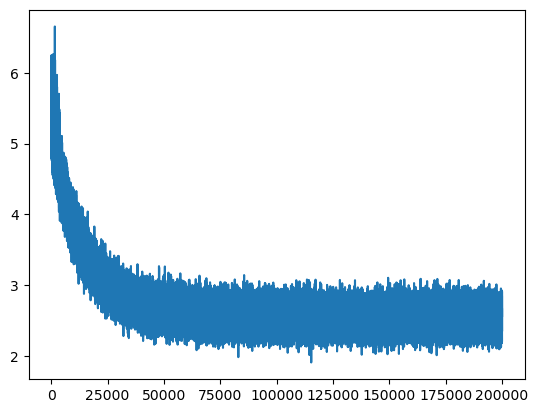

In [287]:
plt.plot(i2, losses2);

I ran a couple of experiments with regularization using different batch sizes (32 and 64), also using randomly vs uniformly initialized weights. In both cases we couldn't improve on the previous result and we had worse loss with the uniform initialization.

**NB** I found out I trained all the above without inclduing C in the list of parameters to be backpropagated on. I'll repeat some of the experiments again while including C

In [302]:
feature_size = 10 #size of feature vector
C = torch.randn((27, feature_size), requires_grad = True)
emb = C[xtr].view(-1, block_size * feature_size)
hidden_size = 200
W1 = torch.randn((block_size * feature_size, hidden_size), requires_grad = True)
b1 = torch.randn(hidden_size, requires_grad = True)
W2 = torch.randn((hidden_size, 27), requires_grad = True)
b2 = torch.randn(27, requires_grad = True)

parameters = [C, W1, b1, W2, b2]

In [303]:
def train(X, Y, num_iters, lr, bs):
    # keep stats
    lossi = []
    iteration = []
    
    for i in range(num_iters):
        ixs = torch.randint(0, X.shape[0], (bs, ))
        # forward
        hidden = torch.tanh((C[X[ixs]].view(-1, block_size * feature_size) @ W1 + b1))
        logits = hidden @ W2 + b2
        loss = F.cross_entropy(logits, Y[ixs])
    
        # backward
        for p in parameters: # zero grads
            p.grad = None
        loss.backward() #backprop

        #lr = 0.1 if i < 10000 else lr
        if i < 100000:
            lr = 0.1
        elif ((i > 100000) and (i < 150000)):
            lr = 0.01
        else:
            lr = lr
        
        for p in parameters: # weight update
            p.data -= lr * p.grad

        lossi.append(loss.item())
        iteration.append(i)
    
    return iteration, lossi

In [304]:
def eval_loss(x, y):
    hidden = torch.tanh(C[x].view(-1, block_size * feature_size) @ W1 + b1)
    logits = hidden @ W2 + b2
    loss = F.cross_entropy(logits, y).item()
    print(f'Loss: {loss}')

In [305]:
i, lossi = train(xtr, ytr, 200000, 0.001, 64)

In [306]:
eval_loss(xtr, ytr), eval_loss(xdev, ydev)

Loss: 2.1048717498779297
Loss: 2.149653911590576


(None, None)

Ok, we get the same losses as before (without C).

#### Use uniform weight initialization:

In [307]:
feature_size = 10 #size of feature vector
C = torch.ones((27, feature_size), requires_grad = True)
emb = C[xtr].view(-1, block_size * feature_size)
hidden_size = 200
W1 = torch.ones((block_size * feature_size, hidden_size), requires_grad = True)
b1 = torch.ones(hidden_size, requires_grad = True)
W2 = torch.ones((hidden_size, 27), requires_grad = True)
b2 = torch.ones(27, requires_grad = True)

parameters = [C, W1, b1, W2, b2]

In [308]:
i, lossi = train(xtr, ytr, 200000, 0.001, 64)

In [309]:
eval_loss(xtr, ytr), eval_loss(xdev, ydev)

Loss: 2.8340959548950195
Loss: 2.827920913696289


(None, None)

Much worse

#### Use Regularization in loss function

In [310]:
feature_size = 10 #size of feature vector
C = torch.randn((27, feature_size), requires_grad = True)
emb = C[xtr].view(-1, block_size * feature_size)
hidden_size = 200
W1 = torch.randn((block_size * feature_size, hidden_size), requires_grad = True)
b1 = torch.randn(hidden_size, requires_grad = True)
W2 = torch.randn((hidden_size, 27), requires_grad = True)
b2 = torch.randn(27, requires_grad = True)

parameters = [C, W1, b1, W2, b2]

In [311]:
def train(X, Y, num_iters, lr, bs):
    # keep stats
    lossi = []
    iteration = []
    
    for i in range(num_iters):
        ixs = torch.randint(0, X.shape[0], (bs, ))
        # forward
        hidden = torch.tanh((C[X[ixs]].view(-1, block_size * feature_size) @ W1 + b1))
        logits = hidden @ W2 + b2
        loss = F.cross_entropy(logits, Y[ixs]) + W1.pow(2).mean() + W2.pow(2).mean()
    
        # backward
        for p in parameters: # zero grads
            p.grad = None
        loss.backward() #backprop

        #lr = 0.1 if i < 10000 else lr
        if i < 100000:
            lr = 0.1
        elif ((i > 100000) and (i < 150000)):
            lr = 0.01
        else:
            lr = lr
        
        for p in parameters: # weight update
            p.data -= lr * p.grad

        lossi.append(loss.item())
        iteration.append(i)
    
    return iteration, lossi

In [312]:
i, lossi = train(xtr, ytr, 200000, 0.001, 64)

In [314]:
eval_loss(xtr, ytr), eval_loss(xdev, ydev)

Loss: 2.059695243835449
Loss: 2.106905698776245


(None, None)

Not bad. Slight improvement.

#### Train without hidden layer

In [319]:
feature_size = 10 #size of feature vector
C = torch.randn((27, feature_size), requires_grad = True)
emb = C[xtr].view(-1, block_size * feature_size)
out_size = 27
W1 = torch.randn((block_size * feature_size, out_size), requires_grad = True)
b1 = torch.randn(out_size, requires_grad = True)

parameters = [C, W1, b1]

In [320]:
# without the hidden layer

def train(X, Y, num_iters, lr, bs):
    # keep stats
    lossi = []
    iteration = []
    
    for i in range(num_iters):
        ixs = torch.randint(0, X.shape[0], (bs, ))
        # forward
        logits = torch.tanh((C[X[ixs]].view(-1, block_size * feature_size) @ W1 + b1))
        loss = F.cross_entropy(logits, Y[ixs]) + W1.pow(2).mean()
    
        # backward
        for p in parameters: # zero grads
            p.grad = None
        loss.backward() #backprop

        #lr = 0.1 if i < 10000 else lr
        if i < 100000:
            lr = 0.1
        elif ((i > 100000) and (i < 150000)):
            lr = 0.01
        else:
            lr = lr
        
        for p in parameters: # weight update
            p.data -= lr * p.grad

        lossi.append(loss.item())
        iteration.append(i)
    
    return iteration, lossi

In [323]:
def eval_loss(x, y):
    logits = torch.tanh(C[x].view(-1, block_size * feature_size) @ W1 + b1)
    loss = F.cross_entropy(logits, y).item()
    print(f'Loss: {loss}')

In [321]:
i, lossi = train(xtr, ytr, 200000, 0.001, 64)

In [324]:
eval_loss(xtr, ytr), eval_loss(xdev, ydev)

Loss: 2.5447640419006348
Loss: 2.5435798168182373


(None, None)

Worse but still works.

In [325]:
eval_loss(xte, yte)

Loss: 2.550022840499878
